<a href="https://colab.research.google.com/github/WoojinJeonkr/DeepLearning/blob/main/Image_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 캡션
- 엔드 투 엔드 예제
- 노트북을 실행할 때 MS-COCO 데이터세트를 다운로드하고 Inception V3를 사용하여   
  이미지의 서브 세트를 사전 처리 및 캐시하고 encoder-decoder 모델을 훈련하고   
  훈련된 모델을 사용하여 새 이미지에 캡션을 생성

## 라이브러리 추가

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## MS-COCO 데이터세트 다운로드 및 준비

In [2]:
# 캡션 파일 다운로드
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

252887040/252872794 [==============================] - 3s 0us/step


In [3]:
# 이미지 파일 다운로드
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 189s 0us/step


## 훈련 세트의 크기 제한

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
# 동일한 이미지 ID를 가진 모든 캡션 그룹화
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [6]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

In [7]:
# 훈련 이미지 설정
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [8]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> Some people sitting in a den watching a television. <end>


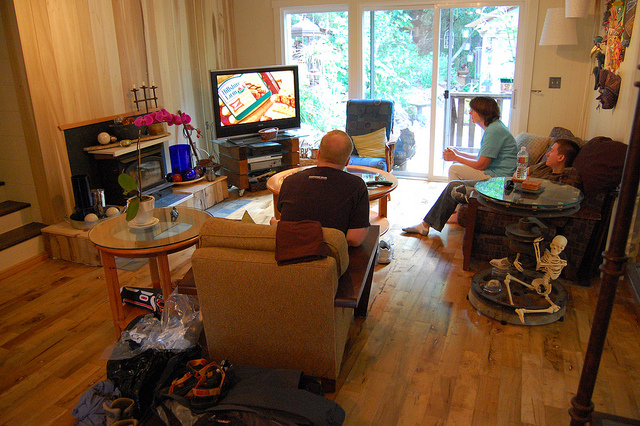

In [9]:
print(train_captions[0])
Image.open(img_name_vector[0])

## InceptionV3 사용하여 이미지 전처리
- 이미지를 299px x 299px로 크기 조정
- preprocess_input 메서드로 이미지를 사전 처리하여 -1에서 1 범위의 픽셀을 포함하도록 이미지 정규화

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## InceptionV3 초기화 및 사전 훈련된 Imagenet 가중치 로드

In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 0s 0us/step


## InceptionV3에서 추출된 특성 캐시

### 진행률 표시줄 보기

In [12]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from tqdm import tqdm

In [14]:
# 특정 이미지 가져오기
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [26:22<00:00,  4.22s/it]


## 캡션 전처리 및 토큰화

In [15]:
# 데이터셋 내의 캡션의 최대 길이 찾기
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [16]:
# 단어 크기를 상위 5,000개 단어로 제한
# 다른 모든 단어는 토큰 "UNK"(알 수 없음)로 대체
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [17]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [18]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [19]:
# 단어 대 인덱스 및 인덱스 대 단어 매핑 생성
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# 모든 시퀀스를 가장 긴 시퀀스와 같은 길이로 채움
max_length = calc_max_length(train_seqs)

## 데이터를 훈련 및 테스트로 분할

In [20]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

In [21]:
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

In [22]:
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

In [23]:
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

In [24]:
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [25]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24014, 24014, 6000, 6000)

## 훈련을 위한 tf.data 데이터세트 생성

In [26]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [27]:
# numpy 파일 불러오기
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [29]:
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

In [30]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## 모델 생성

In [31]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    score = self.V(attention_hidden_layer)

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [32]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [33]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state = self.gru(x)

    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [34]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [35]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [36]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## 체크포인트

In [37]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [38]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## 훈련하기

In [39]:
loss_plot = []

In [40]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [41]:
EPOCHS = 5

In [42]:
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.1904
Epoch 1 Batch 100 Loss 1.1885
Epoch 1 Batch 200 Loss 1.0876
Epoch 1 Batch 300 Loss 0.8940
Epoch 1 Loss 1.103596
Time taken for 1 epoch 2326.23 sec

Epoch 2 Batch 0 Loss 0.8227
Epoch 2 Batch 100 Loss 0.8681
Epoch 2 Batch 200 Loss 0.7866
Epoch 2 Batch 300 Loss 0.8026
Epoch 2 Loss 0.841251
Time taken for 1 epoch 2227.65 sec

Epoch 3 Batch 0 Loss 0.7780
Epoch 3 Batch 100 Loss 0.7629
Epoch 3 Batch 200 Loss 0.6886
Epoch 3 Batch 300 Loss 0.7255
Epoch 3 Loss 0.752993
Time taken for 1 epoch 2241.95 sec

Epoch 4 Batch 0 Loss 0.7657
Epoch 4 Batch 100 Loss 0.6641
Epoch 4 Batch 200 Loss 0.7158
Epoch 4 Batch 300 Loss 0.6657
Epoch 4 Loss 0.698713
Time taken for 1 epoch 2233.76 sec

Epoch 5 Batch 0 Loss 0.7061
Epoch 5 Batch 100 Loss 0.7090
Epoch 5 Batch 200 Loss 0.6447
Epoch 5 Batch 300 Loss 0.6143
Epoch 5 Loss 0.655561
Time taken for 1 epoch 2243.25 sec



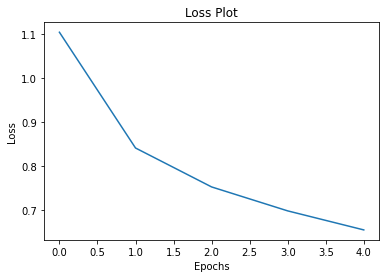

In [43]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()